In [1]:
# Dataset Used https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

import numpy as np
import pandas as pd
import torch 
import os
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from PIL import Image
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
from torchvision.utils import save_image
from torchvision.utils import make_grid

In [2]:
batch_size = 64
image_size = 256
num_epochs = 10

In [3]:
transforms = T.Compose([
    T.Resize((256,256)),
    T.ToTensor()
])

In [4]:
class DatasetFromFolder(data.Dataset):
    def __init__(self,folder,normal,pneumonia,transform):
        super().__init__()
        self.transform = transform
        
        normal_path = os.path.join(folder,normal)
        pneumonia_path = os.path.join(folder,pneumonia)
        
        normal_images = [(os.path.join(normal_path,x),0.0) for x in os.listdir(normal_path)]
        pneumonia_images = [(os.path.join(pneumonia_path,x),1.0) for x in os.listdir(pneumonia_path)]

        max_len = min(len(normal_images),len(pneumonia_images))
        self.images = normal_images[:max_len] + pneumonia_images[:max_len]
    
    def __getitem__(self,index):
        img = self.images[index][0]
        img = Image.open(img).convert("RGB")
        img = self.transform(img)
        return img,self.images[index][1]
    
    def __len__(self):
        return len(self.images)

In [5]:
train_ds = DatasetFromFolder('../input/chest-xray-pneumonia/chest_xray/train','NORMAL','PNEUMONIA',transforms)
train_dl = DataLoader(train_ds,batch_size,shuffle=True)

test_ds = DatasetFromFolder('../input/chest-xray-pneumonia/chest_xray/test','NORMAL','PNEUMONIA',transforms)
test_dl = DataLoader(test_ds,batch_size,shuffle=True)

val_ds = DatasetFromFolder('../input/chest-xray-pneumonia/chest_xray/val','NORMAL','PNEUMONIA',transforms)
val_dl = DataLoader(val_ds,batch_size,shuffle=True)

In [6]:
def show_images(images,nmax=16):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(make_grid(images.detach()[:nmax],nrow=4).permute(1,2,0))

def show_batch(dl):
    for images,labels in dl:
        show_images(images)
        break

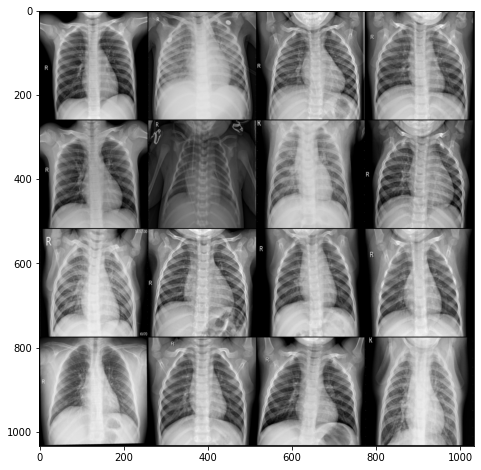

In [7]:
show_batch(train_dl)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
model = models.resnet50(pretrained=True) 
num_features = model.fc.in_features 
model.fc = nn.Sequential(
    nn.Linear(num_features,512),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(512,128),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(64,1)
)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
criterion = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(model.parameters(),lr=0.0001)
scheduler = StepLR(opt,step_size =1,gamma=0.1)

In [11]:
def test_acc():
    for image,label in test_dl:
        image = image.to(device)
        label = label.to(device)
        preds = model(image)
        ped = torch.sigmoid(preds).squeeze(1).detach().cpu().numpy().round()
        lab = label.detach().cpu().numpy()
        acc = (ped==lab).sum()/len(ped==lab)
        break
    return acc.item()

In [12]:
for epoch in range(10):
    for images,labels in train_dl:
        torch.cuda.empty_cache()
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)
        loss = criterion(preds,labels.type(torch.float).unsqueeze(1))
        opt.zero_grad()
        loss.backward()
        opt.step()
        print("Epoch : {} Loss : {} Accuracy : {} Lr : {}".format(epoch,loss.item(),test_acc(),opt.param_groups[0]["lr"]))
    scheduler.step()

Epoch : 0 Loss : 0.6949634552001953 Accuracy : 0.46875 Lr : 0.0001
Epoch : 0 Loss : 0.6891679763793945 Accuracy : 0.609375 Lr : 0.0001
Epoch : 0 Loss : 0.6837787628173828 Accuracy : 0.484375 Lr : 0.0001
Epoch : 0 Loss : 0.6737271547317505 Accuracy : 0.5 Lr : 0.0001
Epoch : 0 Loss : 0.6841220259666443 Accuracy : 0.515625 Lr : 0.0001
Epoch : 0 Loss : 0.6620292663574219 Accuracy : 0.5 Lr : 0.0001
Epoch : 0 Loss : 0.6600097417831421 Accuracy : 0.5625 Lr : 0.0001
Epoch : 0 Loss : 0.667564332485199 Accuracy : 0.640625 Lr : 0.0001
Epoch : 0 Loss : 0.6385542154312134 Accuracy : 0.703125 Lr : 0.0001
Epoch : 0 Loss : 0.6385935544967651 Accuracy : 0.671875 Lr : 0.0001
Epoch : 0 Loss : 0.6267761588096619 Accuracy : 0.71875 Lr : 0.0001
Epoch : 0 Loss : 0.5990340113639832 Accuracy : 0.765625 Lr : 0.0001
Epoch : 0 Loss : 0.5865540504455566 Accuracy : 0.765625 Lr : 0.0001
Epoch : 0 Loss : 0.5790022611618042 Accuracy : 0.828125 Lr : 0.0001
Epoch : 0 Loss : 0.5559172034263611 Accuracy : 0.734375 Lr : 0.

tensor([0.], grad_fn=<SelectBackward>) tensor(0., dtype=torch.float64)


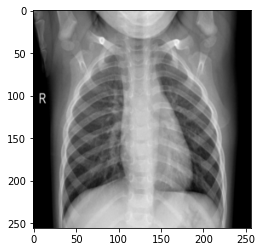

In [13]:
for image,label in test_dl:
    torch.cuda.empty_cache()
    model = model.to('cpu')
    out = model(image)
    print(torch.round(torch.sigmoid(out))[0],label[0])
    plt.imshow(image[0].permute(1,2,0))
    break